# Smartwatch Activity Recognition using TSFEL

On this example we will perform Human Activty Recognition using our library **Time Series Feature Extraction Library**.

To perform this example every cell must be executed. To do so click run ([  ]) in the top left of every cell.

The first step consists on importing the library. To do that press play. 

The import can take a few seconds, but the run button will change so that you know the import has started and ended.

A warning will appear to reset all runtimes before running, click to accept.

# Imports

In [1]:
#@title Import Time Series Feature Extraction Library
import warnings
warnings.filterwarnings('ignore')
!pip install https://github.com/fraunhoferportugal/tsfel/archive/v0.1.3.zip 2>&1;
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip >/dev/null 2>&1;

     \ 634kB 565kB/s
  Created wheel for tsfel: filename=tsfel-0.1.3.dev0-cp36-none-any.whl size=42855 sha256=9ce6c1d445596cb3e3cb48bee4b528047017e33f771fb249b2b0a8231569be3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-c8aj_5g6/wheels/51/73/79/4f951722f29d4a378f4fcfe6ea7b865e05bc9c23a9ddf4746d
Successfully built tsfel
  Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1


To check if everything was correctly imported, access "Files" (on the left side of the screen) and press "Refresh". If UCI HAR Dataset folder does not appear run Import Time Series Features library again.

In [0]:
# Import libraries
import glob
import secrets
import pandas as pd
import numpy as np
import tsfel
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy import interpolate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Unzip dataset
zip_ref = zipfile.ZipFile("wisdm-dataset.zip", 'r')
zip_ref.extractall()
zip_ref.close()

# Auxiliary Methods

**Data pre-processing**

Method to interpolate accelerometer and gyroscope data to the same time interval.

In [0]:
def pre_process_data(data_acc, data_gyro, fs):
    """This function interpolates the accelerometer and gyroscope data to 
    the same time interval.

    Parameters
    ----------
    data_acc nd-array
    Accelerometer data of specified activity
    data_gyro nd-array
    Gyroscope data of specified activity
    fs int
    Sampling frequency

    Returns
    -------
    Interpolated data (nd-array)

    """
    time_acc = (data_acc[:, 2])/1e9 - data_acc[0, 2]/1e9
    data_act_acc = data_acc[:, 3:]

    time_gyro = (data_gyro[:, 2])/1e9 - data_gyro[0, 2]/1e9
    data_act_gyro = data_gyro[:, 3:]

    # time interval for interpolation
    t0 = np.max([time_acc[0], time_gyro[0]])
    tn = np.min([time_acc[-1], time_gyro[-1]])
    time_new = np.linspace(t0, tn, int((tn - t0) / ((1 / fs))))

    # interpolation
    acc_data = np.array([interpolate.interp1d(time_acc, data_act_acc[:, ax])(time_new) for ax in range(np.shape(data_act_acc)[1])]).T
    gyro_data = np.array([interpolate.interp1d(time_gyro, data_act_gyro[:, ax])(time_new) for ax in range(np.shape(data_act_gyro)[1])]).T

    # concatenate interpolated data
    data = np.concatenate((acc_data, gyro_data), axis = 1)

    return data

**Renaming features keys according to sensor names**

In [0]:
def update_features_names(features, sensor_names):
    """This function updates features keys according to sensor names.

    Parameters
    ----------
    features DataFrame
    sensor_names Dict
        dictionary whose keys are the old sensor name and values are 
    the new sensor name.

    Returns
    -------
    features Dataframe with updated keys
    """
    sensor_names = {'0_':'accx_', '1_':'accy_', '2_':'accz_', '3_':'gyrox_', '4_':'gyroy_', '5_':'gyroz_'}
    features_names = '-'.join(list(features.keys()))

    for i in range(len(sensor_names)):
        features_names = features_names.replace(list(sensor_names.keys())[i], list(sensor_names.values())[i])
    features_names = features_names.split('-')

    for j in range(len(features_names)):
        features = features.rename(columns={list(features.keys())[j]:features_names[j]}) 

    return features


# Dataset

The dataset we will be using is open-source. It is provided by UCI and it was performed by 51 subjects using a smartphone on their pocket and a smartwatch on their dominant hand. It contains a total of 18 activities whose labels are given by the following letters:

* Walking = A
* Jogging = B
* Stairs = C
* Sitting = D
* Standing = E
* Typing = F
* Brushing Teeth = G
* Eating Soup = H
* Eating Chips = I
* Eating Pasta = J
* Drinking from Cup = K
* Eating Sandwich = L
* Kicking Soccer Ball = M
* Playing Catch w/Tennis Ball = O
* Dribblinlg Basketball = P
* Writing = Q
* Clapping = R
* Folding Clothes = S

For this classification problem only the smartwatch data will be used.

The dataset used in this example can be found [here](https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+).

# Load Data

Files from accelerometer and gyroscope of the smartwatch will be loaded.


In [0]:
# Loading smartwatch data files
watch_files_acc = np.sort(glob.glob('wisdm-dataset/raw/watch/accel' + "*/**.txt", recursive=True))
watch_files_gyro = np.sort(glob.glob('wisdm-dataset/raw/watch/gyro' + "*/**.txt", recursive=True))

#Defining train and test

Data will be splitted into equal sized windows according to the performed activity.

Train and Test sets will be defined.

In [0]:
all_acc_data = [np.array(pd.read_csv(acc_file, header = None, delimiter = ',', comment=';')) for acc_file in watch_files_acc]
all_gyro_data = [np.array(pd.read_csv(gyro_file, header = None, delimiter = ',', comment=';')) for gyro_file in watch_files_gyro]

x_test = []
x_train = []
y_test = []
y_train = []
activities = np.unique(np.vstack(all_acc_data)[:,1]).astype(str)
ntrain = 45
fs = 20 # According to dataset information
overlap = 0
ws = 200 # 10 second windows

for acq, (acc_data, gyro_data) in enumerate(zip(all_acc_data, all_gyro_data)):

    windows = []
    labels = []

    for act in activities:
        act_acc, act_gyro = np.where(acc_data == act)[0], np.where(gyro_data == act)[0]
        acc_data_act, gyro_data_act = acc_data[act_acc, :], gyro_data[act_gyro, :]
        ids_act_acc = np.append(0, np.where(np.diff(act_acc)>1)[0]+1)
        ids_act_gyro = np.append(0, np.where(np.diff(act_gyro)>1)[0]+1)

        if len(act_acc) == 0 or len(act_gyro) == 0:
            continue

        # Only one acquisition of act
        if (len(ids_act_gyro) == 1) and (len(ids_act_acc) == 1):
            data = pre_process_data(acc_data_act, gyro_data_act, fs)
            w = tsfel.signal_window_spliter(data.astype(float), ws, overlap) 
            windows.append(w)
            labels.append(np.repeat(act, len(w)))
        else:
            # More than one acquisition of act
            acc_data_acts = [acc_data_act[ids_act_acc[i]:ids_act_acc[i+1], :] for i in range(len(ids_act_acc)-1)]
            gyro_data_acts = [gyro_data_act[ids_act_gyro[i]:ids_act_gyro[i+1], :] for i in range(len(ids_act_gyro)-1)]

            for acc_data_act, gyro_data_act in zip(acc_data_acts, gyro_data_acts):
                data = pre_process_data(acc_data_act, gyro_data_act, fs)
                w = tsfel.signal_window_spliter(data.astype(float), ws, overlap)   
                windows.append(w)
                labels.append(np.repeat(act, len(w)))

    # Consider ntrain acquisitions for train and the remaining for test
    if acq<=ntrain:
        x_train.append(windows)
        y_train.append(np.hstack(labels))
    else:
        x_test.append(windows)
        y_test.append(np.hstack(labels))


In [0]:
y_train = np.hstack(y_train)
y_test = np.hstack(y_test)
x_train = list(itertools.chain(*list(itertools.chain(*x_train))))
x_test = list(itertools.chain(*list(itertools.chain(*x_test))))

# Feature Extraction

Through **Feature Extraction** methodologies, the data is translated into a feature vecture containing information about the signal properties of each window. These properties can be classifier according to their domain as Time, Frequency and Statistical features and allow to characterise the signal in a compact way, enhancing its chracteristics.

In this classification problem only features from the temporal domain will be used as input to the machine learning classifier.


In [8]:
cfg_file = tsfel.get_features_by_domain('temporal')
x_train_feat = tsfel.time_series_features_extractor(cfg_file, x_train, fs = fs)
x_test_feat = tsfel.time_series_features_extractor(cfg_file, x_test, fs = fs)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


# Feature Selection

After the sensor data is extracted, redundancies and noise should be removed. Thus, minimising the algorithm's error, time and computational complexity. 

In [0]:
sensor_names = {'0_':'accx_', '1_':'accy_', '2_':'accz_', '3_':'gyrox_', '4_':'gyroy_', '5_':'gyroz_'}
x_train_feat = update_features_names(x_train_feat, sensor_names)
x_test_feat = update_features_names(x_test_feat, sensor_names)

**Removal of highly correlated features**



In [10]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(x_train_feat)
print('Highly correlated features: ' + '; '.join(corr_features))

X_train = x_train_feat.copy()
X_test = x_test_feat.copy()

for rej in corr_features:
    X_train = X_train.drop(rej, axis=1)
    X_test = X_test.drop(rej, axis=1)

Highly correlated features: accx_Autocorrelation; accy_Autocorrelation; accz_Autocorrelation; gyrox_Autocorrelation; gyroy_Autocorrelation; gyroz_Autocorrelation; accx_Median absolute diff; accy_Median absolute diff; accz_Median absolute diff; gyrox_Median absolute diff; gyroy_Median absolute diff; gyroz_Median absolute diff; accx_Minimum peaks; accy_Minimum peaks; accz_Minimum peaks; gyrox_Minimum peaks; gyroy_Minimum peaks; gyroz_Minimum peaks; accx_Signal distance; accy_Signal distance; accz_Signal distance; gyrox_Signal distance; gyroy_Signal distance; gyroz_Signal distance; accx_Sum absolute diff; accy_Sum absolute diff; accz_Sum absolute diff; gyrox_Sum absolute diff; gyroy_Sum absolute diff; gyroz_Sum absolute diff; accx_Total energy; accy_Total energy; accz_Total energy; gyrox_Total energy; gyroy_Total energy; gyroz_Total energy


**Remove constant features**



In [0]:
ids_const_features = np.where(np.sum(np.diff(X_train, axis = 0), axis = 0) == 0)[0]

X_train = X_train.drop(X_train.columns[ids_const_features], axis = 1)
X_test = X_test.drop(X_test.columns[ids_const_features], axis = 1)

# Features Normalization

**Handling eventual missing values from the feature extraction**

In [0]:
X_train.replace([np.inf, -np.inf], np.nan, inplace = True)
X_train.fillna(X_train.mean(), inplace = True)

X_test.replace([np.inf, -np.inf], np.nan, inplace = True)
X_test.fillna(X_test.mean(), inplace = True)

**Normalizing features**

In [0]:
x_train_mean = np.mean(np.array(X_train), axis = 0)
x_train_std = np.std(np.array(X_train), axis = 0)
X_train = (X_train-x_train_mean)/x_train_std
X_test = (X_test-x_train_mean)/x_train_std

# Classification

In this example the classification is performed with a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier.

                 precision    recall  f1-score   support

        walking       0.84      0.60      0.70        85
        jogging       1.00      0.95      0.98        85
         stairs       0.86      0.74      0.80        85
        sitting       0.65      0.62      0.64        85
       standing       0.63      0.79      0.70        85
         typing       0.81      0.98      0.89        85
 brushing teeth       0.95      0.91      0.93        85
    eating soup       0.66      0.45      0.53        85
   eating chips       0.38      0.53      0.45        85
   eating pasta       0.75      0.67      0.71        85
       drinking       0.70      0.58      0.63        85
eating sandwich       0.40      0.34      0.37        85
        kicking       0.68      0.72      0.70       103
  playing catch       0.72      0.93      0.81        85
     dribblinlg       0.97      0.87      0.92        85
        writing       0.96      0.95      0.96        85
       clapping       0.89    

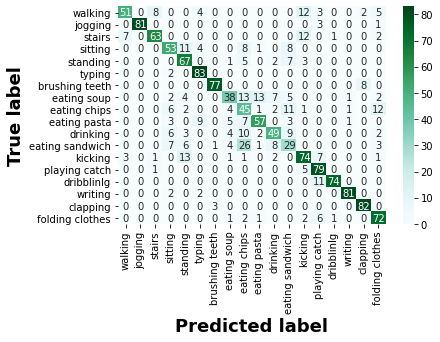

In [14]:
classifier = RandomForestClassifier()
activities = ['walking', 'jogging', 'stairs', 'sitting', 'standing', 'typing', 
              'brushing teeth', 'eating soup', 'eating chips', 'eating pasta', 
              'drinking', 'eating sandwich', 'kicking', 'playing catch', 
              'dribblinlg', 'writing', 'clapping', 'folding clothes']

# Train The Classifier
classifier.fit(X_train, y_train.ravel())

# Predict Test Data
y_predict = classifier.predict(X_test)

# Get the Classification Report
accuracy = accuracy_score(y_test, y_predict)*100
print(classification_report(y_test, y_predict, target_names = activities))
print('Accuracy: ' + str(accuracy) + '%')

# Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activities], columns = [i for i in activities])
plt.figure()
ax = sns.heatmap(df_cm, cbar = True, cmap="BuGn", annot = True, fmt = 'd')
plt.setp(ax.get_xticklabels(), rotation = 90)
plt.ylabel('True label', fontweight = 'bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 18)
plt.show()

# Conclusion

The final accuracy obtained by feeding a Random Forest classifier with only temporal domain features is around 75%.   

As it can be seen in the confusion matrix, eating chips activity is the class with more misclassified samples. This activity is being mainly classified as eating sandwich activity, which is reasonable since both activities rely almost on the same hand movement.

Although the overall results are satisfying, the increase of the classifier performance may be achieved by extracting features from all domains (temporal, statistical and spectral) and by including smartphone's data.